# Imports

In [56]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import keras_tuner as kt

np.random.seed(42)
tf.random.set_seed(42)

Load dataset and split into train, test and validation sets

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

#X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
#X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Build the search grid and return the model that the oracle selects

In [83]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256, step=16)
    optimizer_name = hp.Choice("optimizer", values=["sgd", "adam", "adamw", "adagrad", "rmsprop", "adamax"])
    momentum = hp.Float("momentum", 0.9, 0.99, default=0.9)
    weight_decay = hp.Float("weight_decay", min_value=1e-6, max_value=1e-2, sampling="log", default=1e-5)
    activation = hp.Choice("activation", values=["relu", "leaky_relu", "elu", "swish"])
    dropout_rate = hp.Float("dropout", 0.2, 0.5, step=0.1)  # tune dropout amount
    initial_learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    decay_rate = hp.Float("decay_rate", min_value=0.90, max_value=0.99, step=0.01, default=0.96)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=1500,
        decay_rate=decay_rate,
        staircase=False
    )

    if optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=momentum, nesterov=True, clipnorm=1.0)
    elif optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0, use_ema=True, ema_momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "adamw":
        optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=weight_decay, clipnorm=1.0)
    elif optimizer_name == "adagrad":
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule, clipnorm=1.0)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, momentum=momentum, clipnorm=1.0)
    else:  # adamax
        optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_schedule, clipnorm=1.0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    model.add(tf.keras.layers.Flatten())

    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            n_neurons,
            kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
            use_bias=False)),
        model.add(tf.keras.layers.BatchNormalization()),
        if activation == "leaky_relu":
            model.add(tf.keras.layers.LeakyReLU(0.1))
        else:
            model.add(tf.keras.layers.Activation(activation))
        model.add(tf.keras.layers.Dropout(dropout_rate))  

    
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=optimizer,
                    metrics=["accuracy"])
    return model

Run the random grid search using def build_model(), optimizing for validation loss

In [84]:
es_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-4
)

beyesian_tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=100,
    overwrite=True,
    directory="fashion_mnist",
    project_name="bayesian_search",
    seed=42)

beyesian_tuner.search(
    X_train,
    y_train,
    epochs=100,
    callbacks=[es_cb],
    validation_data=(X_valid, y_valid))



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |n_hidden
16                |16                |n_neurons
adamw             |adamw             |optimizer
0.92447           |0.92447           |momentum
0.0035733         |0.0035733         |weight_decay
leaky_relu        |leaky_relu        |activation
0.3               |0.3               |dropout
0.00013607        |0.00013607        |learning_rate
0.94              |0.94              |decay_rate

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 775us/step - accuracy: 0.3082 - loss: 1.9496 - val_accuracy: 0.7247 - val_loss: 1.4027
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.4685 - loss: 1.5727 - val_accuracy: 0.7730 - val_loss: 1.0860
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.5277 - loss: 1.3902 - val_accuracy: 0.7842 - val_loss: 0.8974
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.5567 - loss:

KeyboardInterrupt: 

Check which hyperparameters yielded the best results

In [ ]:
best_trial = beyesian_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()
print("val_accuracy :", best_trial.metrics.get_last_value("val_accuracy"))

Trial 13 summary
Hyperparameters:
n_hidden: 2
n_neurons: 132
learning_rate: 0.0021830821185095817
optimizer: adagrad
momentum: 0.9065129916842524
weight_decay: 5.939437813279242e-06
activation: relu
Score: 0.32079580426216125
val_accuracy : 0.8843333125114441


In [ ]:
best_hps = beyesian_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

best_model = build_model(best_hps)

history = best_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[es_cb]
)

{'n_hidden': 2, 'n_neurons': 132, 'learning_rate': 0.0021830821185095817, 'optimizer': 'adagrad', 'momentum': 0.9065129916842524, 'weight_decay': 5.939437813279242e-06, 'activation': 'relu'}
Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7113 - loss: 0.8823 - val_accuracy: 0.8018 - val_loss: 0.5798
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.8047 - loss: 0.5677 - val_accuracy: 0.8267 - val_loss: 0.4949
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.8244 - loss: 0.5066 - val_accuracy: 0.8383 - val_loss: 0.4570
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - accuracy: 0.8366 - loss: 0.4724 - val_accuracy: 0.8463 - val_loss: 0.4343
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8450 - loss: 0.4493 - val_accuracy: 0.8506 - val_loss: 0.4190
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8495 - loss: 0.4319 - val_accuracy: 0.8547 - val_loss: 0.4077
Epoch 7/100
1500/

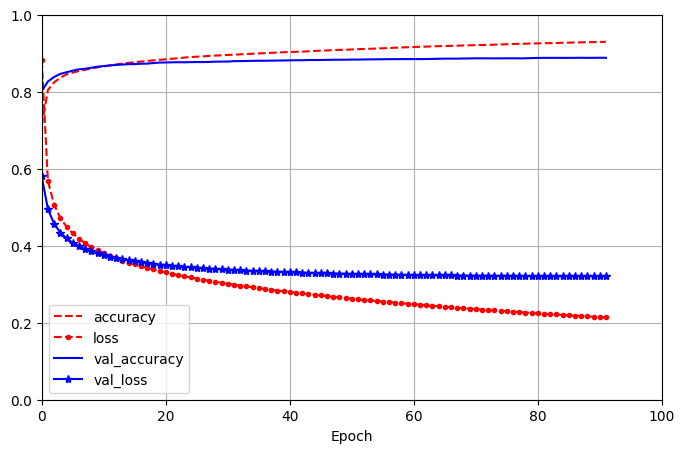

In [73]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 100], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

Initialize the weights using He-initiliazation, suitable for the ReLU activation function because it compensates for the dying ReLU problem

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


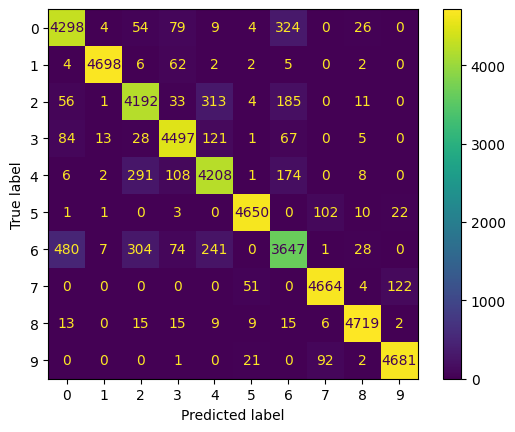

In [74]:
y_prediction_proba = best_model.predict(X_valid)
y_prediction = y_prediction_proba.argmax(axis=1)
predictions_proba = best_model.predict(X_train)
predictions = predictions_proba.argmax(axis=1)
ConfusionMatrixDisplay.from_predictions(y_train, predictions)
plt.show()

In [75]:
best_model.evaluate(X_valid, y_valid)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.8880 - loss: 0.3209


[0.32086610794067383, 0.8880000114440918]

In [79]:
best_model.save("best_so_far.keras")

In [80]:
best_model_so_far = tf.keras.models.load_model("best_so_far.keras")

In [78]:
best_model_so_far.evaluate(X_valid, y_valid)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.8880 - loss: 0.3209


[0.32086610794067383, 0.8880000114440918]